# Sharpe Momentum Trading Strategies

Simeon Bikorimana

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.spatial.distance as distance
import statsmodels.api as sm
from statsmodels import regression
import time
from datetime import datetime, date, time, timedelta

In [5]:
data = pd.read_csv('/Users/simeon/Desktop/Time Series Analysis/all_stocks_5yr.csv').set_index('date')
data = data[['close','Name']]
data.head()

,close,Name
date,,
2013-02-08,14.75,AAL
2013-02-11,14.46,AAL
2013-02-12,14.27,AAL
2013-02-13,14.66,AAL
2013-02-14,13.99,AAL


In [6]:
SP500 = pd.read_csv('/Users/simeon/Desktop/Time Series Analysis/^GSPC.csv').set_index('Date')
SP500 = SP500['Adj Close']
SP500.head()
len(SP500)

1259

In [7]:
# Timeline of changing holding position
index = pd.to_datetime(data[data['Name'] == 'AAL'].index)
timeline = index[20::10]

# There are total 505 stocks in SP500
symbols = set(data['Name'].values)
symbols = sorted(list(symbols))

In [8]:
def sharperank(data,time):
    """
    Function:   This function rank the returns of all stocks in the last 20 days
    Input:      data
                the time we decide to change the position
    Output:     buylist and shortlist of the companies we decide to choose base on the current sharpe ratio rank
    """
    
    data.index = pd.to_datetime(data.index)
    sharpe = {'symbol':[], 'ratio':[]}
    for symbol in symbols:
        sharpe['symbol'].append(symbol)
        chunckdata = data[data['Name'] == symbol]
        chunckdata = chunckdata[(chunckdata.index >= (time - timedelta(20))) & (chunckdata.index <= time)]
        
        # get sharpe ratios of all stocks
        ret = chunckdata[chunckdata['Name'] == symbol]['close'].pct_change().dropna()
        ratio = ret.mean() / ret.std()
        sharpe['ratio'].append(ratio)
        
    # sort sharpe ratios
    sharpe = pd.DataFrame(sharpe)
    sorted_sharpe = sharpe.sort_values(by = ['ratio'],ascending = False)
    sorted_sharpe = sorted_sharpe.reset_index()
        
    # According to the ranks, choose to long the top 10% stocks and short the bottom 10% stocks
    sorted_sharpe = sorted_sharpe[0:int(sorted_sharpe.shape[0]*1/5)]
    buylist = sorted_sharpe['symbol'].tolist()
    sorted_sharpe_short = sorted_sharpe[int(sorted_sharpe.shape[0]*4/5):]
    shortlist = sorted_sharpe_short['symbol'].tolist()
    
    return(buylist,shortlist)

In [9]:
def valid_companies(buylist,shortlist):
    """
    Function: This funciton checks whether this timeline has this stock
    Input:    buylist we get from sharpe rank function
    Output:   number of the buylist
              valid new buylist
    """
    
    buylist_new = []
    shortlist_new = []
    for buy in buylist:
        if timeline[0] in (data[data['Name'] == buy].index):
            buylist_new.append(buy)
    number1 = len(buylist_new)
    
    for short in shortlist:
        if timeline[0] in (data[data['Name'] == short].index):
            shortlist_new.append(short)
    number2 = len(shortlist_new)
    return(number1,buylist_new,number2,shortlist_new)

### Get the capital changing process using Sharpe Momentum strategy

In [10]:
capital_base = 1000000

capital_change = []
for i in np.arange(len(timeline)-1):
    pricelist_buy = []
    sharelist_buy = []
    pricelist_short = []
    sharelist_short = []
    
    # get the new buylist and new shortlist
    buylist, shortlist = sharperank(data,timeline[i])
    number1, buylist_new, number2, shortlist_new = valid_companies(buylist,shortlist)

    
    # get the money we put in each stock. Here we use equal holding position
    money = capital_base / number1
    
    # Buy stocks we choose
    for buy in buylist_new:
        price = data[data['Name'] == buy][data[data['Name'] == buy].index == timeline[i]]['close'].values[0]
        # floor down to integer shares
        share = int(money / price)
        sharelist_buy.append(share)
        pricelist_buy.append(price)  
        
    # Short stocks we choose to hedge
    for short in shortlist_new:
        price = data[data['Name'] == short][data[data['Name'] == short].index == timeline[i]]['close'].values[0]
        # floor down to integer shares
        share = int(money / price)
        sharelist_short.append(share)
        pricelist_short.append(price)  
    
    # Include transaction cost, here we consider $2/transaction
    moneyleft = capital_base - np.array(pricelist_buy).dot(np.array(sharelist_buy))
    
    # get the total capital we have at the next refreshing date
    pricelistbuy_new = []
    pricelistshort_new = []
    for buy in buylist_new:
        price = data[data['Name'] == buy][data[data['Name'] == buy].index == timeline[i+1]]['close'].values[0]
        pricelistbuy_new.append(price)
    
    for short in shortlist_new:
        price = data[data['Name'] == short][data[data['Name'] == short].index == timeline[i+1]]['close'].values[0]
        pricelistshort_new.append(price)
        
    pricelistshort_new = np.array(pricelist_short) - np.array(pricelistshort_new)
    
    capital = np.array(pricelistbuy_new).dot(np.array(sharelist_buy)) + np.array(pricelistshort_new).dot(np.array(sharelist_short)) + moneyleft
    print(capital)
    capital_change.append(capital)
    # change captial_base to what we have now
    capital_base = capital

1007344.575
1013890.2865999999
1034659.0515999998
1046359.4143999998
1064591.8706
1030075.6499999999
1043620.3609
1040631.0146000001
1071476.2511000002
1083986.5035000003
1059453.7695000004
1056198.6174000003
1079502.9008000004
1085331.0438000006
1093752.101300001
1114065.2400000012
1106990.6952000011
1126255.675200001
1128082.8072000009
1145220.5870000008
1159658.680200001
1171376.297200001
1154134.3822000013
1193124.5010000013
1211668.8609000011
1200786.1707000015
1190014.5407000014
1192910.5401000013
1198210.445100001
1204508.0321000014
1218302.833400001
1227448.993400001
1240522.646300001
1234812.699000001
1222806.406500001
1201745.182500001
1235291.9266000013
1236927.6923000012
1218861.095400001
1197853.8694000007
1221407.2291000003
1256795.2831000001
1265661.3880999999
1282828.3364
1283591.9964000003
1261966.2214000004
1290754.4219000002
1286033.5878000003
1327245.3980000003
1322267.8986
1338667.9649
1313320.4899
1312724.2226
1325595.6268999998
1320877.2688999998
1314784.68789999

In [12]:
capital_change = pd.DataFrame({'Date':timeline[:-1],
                               'Capital':capital_change}).set_index('Date')

### Get the capital changing process by holding benchmark index(SP500 index)

In [13]:
SP500_return = SP500.pct_change().dropna()
capital_base = 1000000
cumulative_return = (1 + SP500_return.values)
SP500_capital = []
SP500_capital.append(capital_base)
for i in range(len(cumulative_return)):
    capital = capital_base * cumulative_return[i]
    SP500_capital.append(capital)
    capital_base = capital
SP500_capital = pd.DataFrame({'Date':index,
                              'Capital':SP500_capital}).set_index('Date')

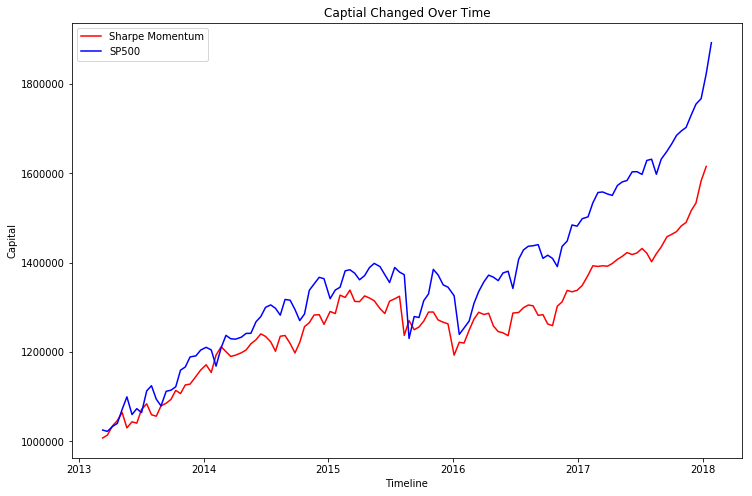

In [14]:
plt.figure(figsize=[12,8])
plt.plot(capital_change, color = 'red',label = 'Sharpe Momentum')
plt.plot(SP500_capital[index.isin(timeline)], color = 'blue', label = 'SP500')
plt.xlabel('Timeline')
plt.ylabel('Capital')
plt.title('Captial Changed Over Time')
plt.legend(loc='best')
plt.show()

In [15]:
strategy_return = ((capital_change.values[-1] - capital_change.values[0]) / capital_change.values[0])[0]
market_return = ((SP500_capital.values[-1] - SP500_capital.values[0]) / SP500_capital.values[0])[0]
yearly_strategy_return = (strategy_return + 1) ** (1/5) - 1
yearly_market_return = (market_return + 1) ** (1/5) - 1
print('Market yearly return is %.3f' % yearly_market_return)
print('Sharpe Momentum Strategy return is %.3f' % yearly_strategy_return)

Market yearly return is 0.121
Sharpe Momentum Strategy return is 0.099


In [24]:
# beta 
beta = np.cov(capital_change['Capital'].values,SP500_capital[index.isin(timeline)]['Capital'][:-1].values)[0][1] / np.var(SP500_capital[index.isin(timeline)]['Capital'][:-1].values)
rf = 0.0234 # three month treasury bill rate
# alpha
alpha = yearly_strategy_return - rf - beta * (yearly_market_return - rf)
# volatility
volatility = np.std(capital_change.pct_change().dropna()['Capital'].values)
# sharpe ratio
sharpe_ratio = yearly_strategy_return / volatility
# information ratio
IR = (yearly_strategy_return - yearly_market_return) / np.std(capital_change.pct_change().dropna()['Capital'].values-SP500_capital[index.isin(timeline)][:-1].pct_change().dropna()['Capital'].values) 
# maximum drawdown
i = np.argmax(np.maximum.accumulate(capital_change['Capital'].values) - capital_change['Capital'].values) # end of the period
j = np.argmax(capital_change['Capital'].values[:i]) # start of period
max_drawdown = 100 * (capital_change['Capital'][i]-capital_change['Capital'][j]) / capital_change['Capital'][j]

info = pd.DataFrame([yearly_strategy_return,beta,alpha,volatility,sharpe_ratio,IR,max_drawdown]).T
info.columns = ['Return','Beta','Alpha','Volatility','Sharpe Ratio','IR','Max Drawdown']
info.index = ['Info']
info

,Return,Beta,Alpha,Volatility,Sharpe Ratio,IR,Max Drawdown
Info,0.099079,0.67973,0.009644,0.015918,6.224337,-0.79477,-10.89079
